In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
n_views = 4
batch_size = 8
model_dir = "../simulation_imagenet"

In [3]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_imagenet1k.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 16
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET1K
n_views = 4
n_trans = 2
augmentation_package = albumentations
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
crop_size = [224, 224]
crop_min_scale = [0.08, 0.08]
crop_max_scale = [1.0, 1.0]
hflip_prob = [0.5, 0.5]
blur_kernel_size = [23, 23]
blur_prob = [1.0, 0.1]
grayscale_prob = [0.2, 0.2]
jitter_brightness = [0.4, 0.4]
jitter_contrast = [0.4, 0.4]
jitter_saturation = [0.2, 0.2]
jitter_hue = [0.1, 0.1]
jitter_prob = [0.8, 0.8]
solarize_prob = [0.0, 0.2]
imagenet_train_dir = /home/guanming/Documents/clap/datasets/imagenet100/train.lmdb
imag

In [4]:
ssl_train_loader,ssl_test_loader,ssl_val_loader = data_utils.get_dataloader(config.DATA,batch_size = 8,
                                                                            num_workers = config.INFO["cpus_per_gpu"],
                                                                            standardized_to_imagenet=False,
                                                                            augment_val_set = True,
                                                                            prefetch_factor=config.INFO["prefetch_factor"],
                                                                            aug_pkg = "torchvision")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

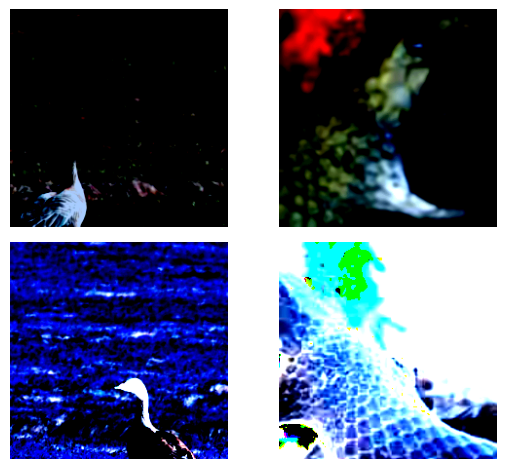

In [5]:
imgs,labels = next(iter(ssl_train_loader))

img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)


In [6]:
def sample_embedding(net,data_loader,count=100):
    embedding_vecs = []
    i = 0
    for i,data in enumerate(data_loader):
        imgs,labels = data
        if i > count - 1:
            break
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = net(imgs)
            preds = torch.reshape(preds,(n_views,batch_size,preds.shape[-1]))
            # save as CPU tensor to save GPU memory
            embedding_vecs.append(preds.detach().cpu())
    embedding_vecs = torch.cat(embedding_vecs,dim=1)
    print(embedding_vecs.shape)
    # preds is [V,B*count,O] dimesional matrix
    com = torch.mean(embedding_vecs,dim=(0,1))
    # make the center of mass of pres locate at the origin
    #embedding_vecs -= com
    # normalize
    embedding_vecs = torch.nn.functional.normalize(embedding_vecs,dim=-1)
    # centers.shape = [B*count,O] for B*ws ellipsoids
    centers = torch.mean(embedding_vecs,dim=0)
    return centers

In [7]:
device = torch.device("cuda:0")  # Use GPU 0
backbone = ssl_model.backbone.to(device)
# make sure the projection head is not removed
for name, param in ssl_model.backbone.projection_head.named_parameters():
    print(f"{name}: {param.shape}")
distances_0 = []
cosine_0 = []
for repeat in range(20):
    _centers = sample_embedding(backbone,ssl_train_loader,count=128)
    _distances = torch.sqrt(torch.sum((_centers[None,:,:] - _centers[:,None,:])**2,dim=-1) + 1e-12)
    _distances = torch.flatten(_distances).detach().cpu().numpy()
    _distances = _distances[np.where(_distances>1e-6)] # exclude self-distances
    _cosine = torch.einsum('ik,jk->ij',_centers,_centers)
    _cosine = torch.flatten(_cosine).detach().cpu().numpy()
    distances_0.append(_distances)
    cosine_0.append(_cosine)
distances_0 = np.concatenate(distances_0)
cosine_0 = np.concatenate(cosine_0)

0.weight: torch.Size([8192, 2048])
0.bias: torch.Size([8192])
2.weight: torch.Size([8192, 8192])
2.bias: torch.Size([8192])
4.weight: torch.Size([512, 8192])
4.bias: torch.Size([512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])


In [8]:
device = torch.device("cuda:0")  # Use GPU 0
last_filename = os.path.join(model_dir,"ssl",'ssl-epoch=99.ckpt')
print(last_filename)
if os.path.isfile(last_filename):
    print(f'Found pretrained model at {last_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(last_filename)
backbone = ssl_model.backbone.to(device)
# make sure the projection head is not removed
for name, param in ssl_model.backbone.projection_head.named_parameters():
    print(f"{name}: {param.shape}")
distances_f = []
cosine_f = []
for repeat in range(20):
    _centers = sample_embedding(backbone,ssl_train_loader,count=128)
    _distances = torch.sqrt(torch.sum((_centers[None,:,:] - _centers[:,None,:])**2,dim=-1) + 1e-12)
    _distances = torch.flatten(_distances).detach().cpu().numpy()
    _distances = _distances[np.where(_distances>1e-6)] # exclude self-distances
    _cosine = torch.einsum('ik,jk->ij',_centers,_centers)
    _cosine = torch.flatten(_cosine).detach().cpu().numpy()
    distances_f.append(_distances)
    cosine_f.append(_cosine)
distances_f = np.concatenate(distances_f)
cosine_f = np.concatenate(cosine_f)

../simulation_imagenet/ssl/ssl-epoch=99.ckpt
Found pretrained model at ../simulation_imagenet/ssl/ssl-epoch=99.ckpt, loading...


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/guanming/miniconda3/envs/mydl/l

max_mem_size is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm
0.weight: torch.Size([8192, 2048])
0.bias: torch.Size([8192])
2.weight: torch.Size([8192, 8192])
2.bias: torch.Size([8192])
4.weight: torch.Size([512, 8192])
4.bias: torch.Size([512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])
torch.Size([4, 1024, 512])


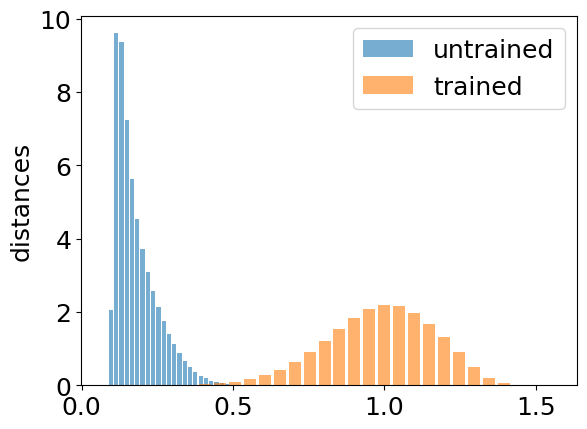

In [9]:
fig1 = plt.figure()
ax1 = fig1.add_axes(111)
ax1.hist(distances_0, bins=30, density=True, rwidth=0.8,alpha=0.6, label='untrained')
ax1.hist(distances_f, bins=30, density=True, rwidth=0.8,alpha=0.6, label='trained')
ax1.set_ylabel("distances",fontsize=18)
ax1.tick_params(axis='both', labelsize=18)
ax1.legend(fontsize=18)
plt.savefig("embedding_distances.png",bbox_inches='tight',dpi=1200) 

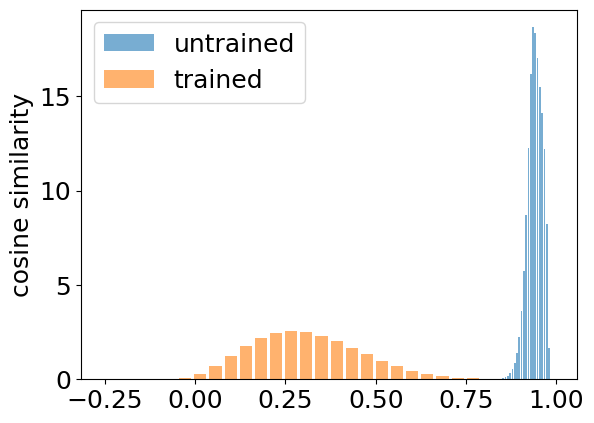

In [10]:
fig2 = plt.figure()
ax2 = fig2.add_axes(111)
ax2.hist(cosine_0, bins=30, density=True, rwidth=0.8,alpha=0.6, label='untrained')
ax2.hist(cosine_f, bins=30, density=True, rwidth=0.8,alpha=0.6, label='trained')
ax2.set_ylabel("cosine similarity",fontsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax2.legend(fontsize=18)
plt.savefig("embedding_cosine.png",bbox_inches='tight',dpi=1200) 